### Import dataset and put into dataloader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os
import glob

# define parameters
batchSize = 16
subset_size = 5500
val_size = 500
test_size = 1000
model_name = "MLP_v1"

# transform
transform_ = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

# split and load datasets
dataset = torchvision.datasets.CIFAR10(root='../src_MLP/data', train=True, download=False, transform=transform_)
_size = len(dataset) - subset_size
subset, _ = random_split(dataset, [subset_size, _size])

train_size = len(subset) - val_size
trainSet, validSet = random_split(subset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='../src_MLP/data', train=False, download=False, transform=transform_)
_size = len(test_dataset) - test_size
testSet, _ = random_split(test_dataset, [test_size, _size])
testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=True, num_workers=2)

print("trainSet size: ", len(trainSet))
print("validSet size: ", len(validSet))
print("testset size: ", len(testSet))

fixed_trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False, num_workers=2)
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

trainSet size:  5000
validSet size:  500
testset size:  1000
cuda:0


### Pre-processing: Convert all rgb images to gray images

images_color shape:  torch.Size([16, 3, 32, 32])


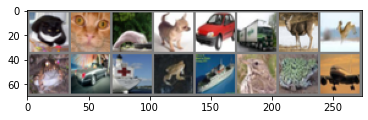

images_gray shape:  torch.Size([16, 1, 32, 32])


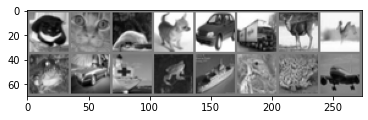

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# create folders
if not os.path.exists('./plot'):
    os.mkdir('./plot/')
if not os.path.exists('./plot/'+model_name+'/'):
    os.mkdir('./plot/'+model_name+'/')
if not os.path.exists('./plot/'+model_name+'/running_inference/'):
    os.mkdir('./plot/'+model_name+'/running_inference/')
if not os.path.exists('./plot/'+model_name+'/inference/'):
    os.mkdir('./plot/'+model_name+'/inference/')
if not os.path.exists('./saved_model'):
    os.mkdir('./saved_model/')

# functions to show an image
def imshow(img, name=""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.savefig('plot/'+model_name+'/'+name+'.png')
    plt.show()

# get some random training images
images_color, labels = next(iter(trainloader))

# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
print("images_color shape: ", images_color.shape)
imshow(torchvision.utils.make_grid(images_color), name="color_sample")
images_gray = images_gray.reshape(batchSize,1,32,32)
print("images_gray shape: ", images_gray.shape)
imshow(torchvision.utils.make_grid(images_gray), name="gray_sample")

### Define the MLP network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 1x32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 3x32x32
        super(MLP_net, self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Linear(2048, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            
            nn.Linear(3072, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            
            nn.Linear(4096, 3072),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        
        return x

model = MLP_net().to(device)

print("GPU: ", next(model.parameters()).is_cuda)

model_path = "./saved_model/"+model_name + ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load(model_path))

GPU:  True


### Define the loss function and optimizer

In [4]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# criterion
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #betas=(0.9, 0.999), eps=1e-08, weight_decay=0
    # optimizer = optim.SGD(mlp_net.parameters(), lr=0.0001, momentum=0.9)

# load previous trained model 
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))
    
# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/"+model_name+"/")
plot_writer = SummaryWriter("./runs_plot/"+model_name+"/")

In [5]:
def make_grid(loaderName, k):
    
    images_color, _ = next(iter(loaderName))
    print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
#     imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference_Train_color")

    images_gray = rgb2gray_batch(images_color)
    print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
#     imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference_Train_gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    imshow(torchvision.utils.make_grid(outputs.detach()), name="running_inference/trainData_"+str(format(k, '04d')))
    
    grid_output = torchvision.utils.make_grid(outputs.detach())
    plot_writer.add_image(str(loaderName), grid_output, k)

### Train the network

Training Mode...
[1,    50] train loss: 0.231
[1,   100] train loss: 0.210
[1,   150] train loss: 0.207
[1,   200] train loss: 0.208
[1,   250] train loss: 0.195
[1,   300] train loss: 0.201
Validation Mode...
[1, _] validation loss: 0.206
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


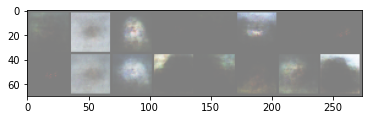

Training Mode...
[2,    50] train loss: 0.204
[2,   100] train loss: 0.203
[2,   150] train loss: 0.190
[2,   200] train loss: 0.196
[2,   250] train loss: 0.191
[2,   300] train loss: 0.191
Validation Mode...
[2, _] validation loss: 0.196
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


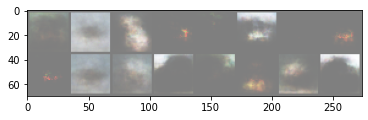

Training Mode...
[3,    50] train loss: 0.197
[3,   100] train loss: 0.190
[3,   150] train loss: 0.189
[3,   200] train loss: 0.200
[3,   250] train loss: 0.190
[3,   300] train loss: 0.187
Validation Mode...
[3, _] validation loss: 0.195
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


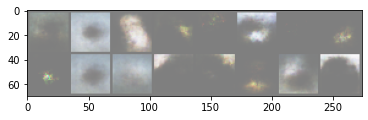

Training Mode...
[4,    50] train loss: 0.199
[4,   100] train loss: 0.192
[4,   150] train loss: 0.186
[4,   200] train loss: 0.186
[4,   250] train loss: 0.189
[4,   300] train loss: 0.190
Validation Mode...
[4, _] validation loss: 0.192
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


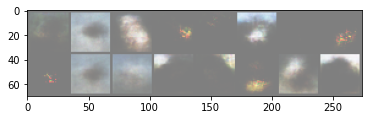

Training Mode...
[5,    50] train loss: 0.189
[5,   100] train loss: 0.189
[5,   150] train loss: 0.184
[5,   200] train loss: 0.188
[5,   250] train loss: 0.182
[5,   300] train loss: 0.194
Validation Mode...
[5, _] validation loss: 0.195
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


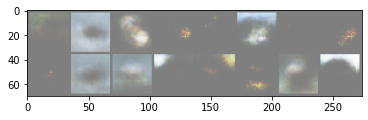

Training Mode...
[6,    50] train loss: 0.186
[6,   100] train loss: 0.185
[6,   150] train loss: 0.189
[6,   200] train loss: 0.182
[6,   250] train loss: 0.181
[6,   300] train loss: 0.188
Validation Mode...
[6, _] validation loss: 0.189
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


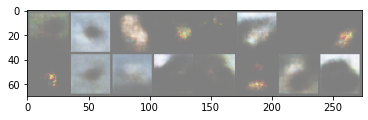

Training Mode...
[7,    50] train loss: 0.188
[7,   100] train loss: 0.183
[7,   150] train loss: 0.179
[7,   200] train loss: 0.191
[7,   250] train loss: 0.187
[7,   300] train loss: 0.182
Validation Mode...
[7, _] validation loss: 0.190
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


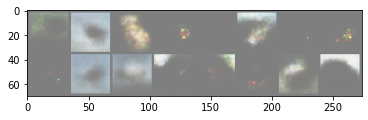

Training Mode...
[8,    50] train loss: 0.179
[8,   100] train loss: 0.183
[8,   150] train loss: 0.185
[8,   200] train loss: 0.184
[8,   250] train loss: 0.180
[8,   300] train loss: 0.186
Validation Mode...
[8, _] validation loss: 0.188
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


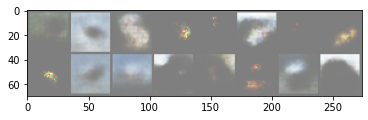

Training Mode...
[9,    50] train loss: 0.181
[9,   100] train loss: 0.184
[9,   150] train loss: 0.183
[9,   200] train loss: 0.181
[9,   250] train loss: 0.181
[9,   300] train loss: 0.184
Validation Mode...
[9, _] validation loss: 0.186
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


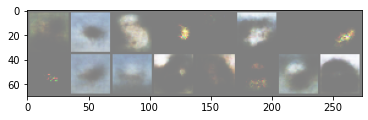

Training Mode...
[10,    50] train loss: 0.179
[10,   100] train loss: 0.180
[10,   150] train loss: 0.180
[10,   200] train loss: 0.178
[10,   250] train loss: 0.182
[10,   300] train loss: 0.185
Validation Mode...
[10, _] validation loss: 0.191
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


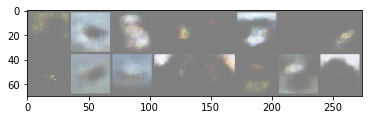

Training Mode...
[11,    50] train loss: 0.175
[11,   100] train loss: 0.181
[11,   150] train loss: 0.182
[11,   200] train loss: 0.184
[11,   250] train loss: 0.181
[11,   300] train loss: 0.177
Validation Mode...
[11, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


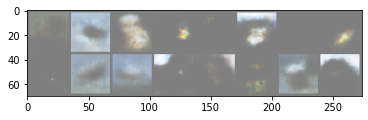

Training Mode...
[12,    50] train loss: 0.173
[12,   100] train loss: 0.185
[12,   150] train loss: 0.181
[12,   200] train loss: 0.176
[12,   250] train loss: 0.177
[12,   300] train loss: 0.178
Validation Mode...
[12, _] validation loss: 0.187
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


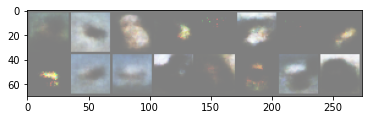

Training Mode...
[13,    50] train loss: 0.180
[13,   100] train loss: 0.176
[13,   150] train loss: 0.176
[13,   200] train loss: 0.178
[13,   250] train loss: 0.172
[13,   300] train loss: 0.186
Validation Mode...
[13, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


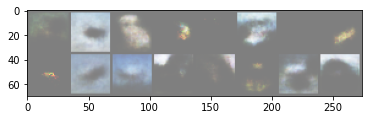

Training Mode...
[14,    50] train loss: 0.178
[14,   100] train loss: 0.170
[14,   150] train loss: 0.181
[14,   200] train loss: 0.176
[14,   250] train loss: 0.173
[14,   300] train loss: 0.178
Validation Mode...
[14, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


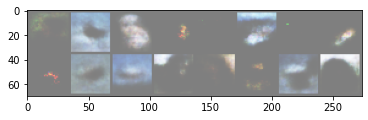

Training Mode...
[15,    50] train loss: 0.173
[15,   100] train loss: 0.175
[15,   150] train loss: 0.179
[15,   200] train loss: 0.178
[15,   250] train loss: 0.175
[15,   300] train loss: 0.172
Validation Mode...
[15, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


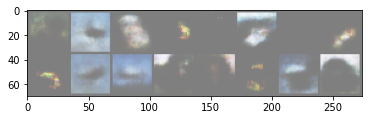

Training Mode...
[16,    50] train loss: 0.172
[16,   100] train loss: 0.173
[16,   150] train loss: 0.181
[16,   200] train loss: 0.168
[16,   250] train loss: 0.182
[16,   300] train loss: 0.175
Validation Mode...
[16, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


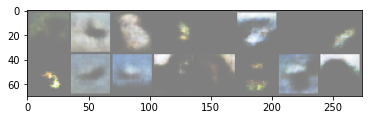

Training Mode...
[17,    50] train loss: 0.172
[17,   100] train loss: 0.173
[17,   150] train loss: 0.173
[17,   200] train loss: 0.174
[17,   250] train loss: 0.176
[17,   300] train loss: 0.175
Validation Mode...
[17, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


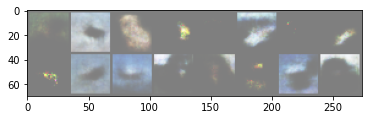

Training Mode...
[18,    50] train loss: 0.173
[18,   100] train loss: 0.172
[18,   150] train loss: 0.182
[18,   200] train loss: 0.174
[18,   250] train loss: 0.174
[18,   300] train loss: 0.171
Validation Mode...
[18, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


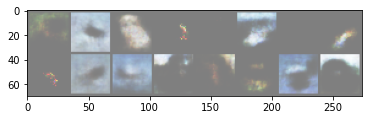

Training Mode...
[19,    50] train loss: 0.182
[19,   100] train loss: 0.174
[19,   150] train loss: 0.168
[19,   200] train loss: 0.176
[19,   250] train loss: 0.171
[19,   300] train loss: 0.170
Validation Mode...
[19, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


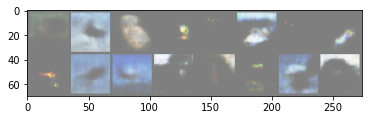

Training Mode...
[20,    50] train loss: 0.175
[20,   100] train loss: 0.174
[20,   150] train loss: 0.170
[20,   200] train loss: 0.170
[20,   250] train loss: 0.172
[20,   300] train loss: 0.172
Validation Mode...
[20, _] validation loss: 0.186
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


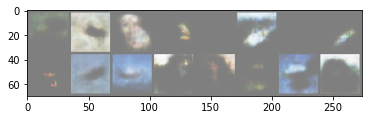

Training Mode...
[21,    50] train loss: 0.166
[21,   100] train loss: 0.172
[21,   150] train loss: 0.169
[21,   200] train loss: 0.174
[21,   250] train loss: 0.176
[21,   300] train loss: 0.173
Validation Mode...
[21, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


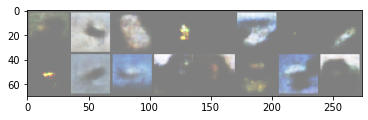

Training Mode...
[22,    50] train loss: 0.173
[22,   100] train loss: 0.175
[22,   150] train loss: 0.169
[22,   200] train loss: 0.170
[22,   250] train loss: 0.168
[22,   300] train loss: 0.169
Validation Mode...
[22, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


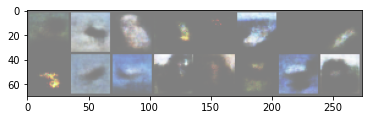

Training Mode...
[23,    50] train loss: 0.173
[23,   100] train loss: 0.171
[23,   150] train loss: 0.176
[23,   200] train loss: 0.162
[23,   250] train loss: 0.176
[23,   300] train loss: 0.168
Validation Mode...
[23, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


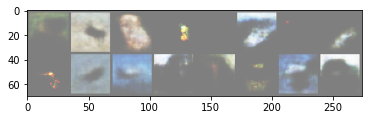

Training Mode...
[24,    50] train loss: 0.163
[24,   100] train loss: 0.168
[24,   150] train loss: 0.170
[24,   200] train loss: 0.168
[24,   250] train loss: 0.180
[24,   300] train loss: 0.169
Validation Mode...
[24, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


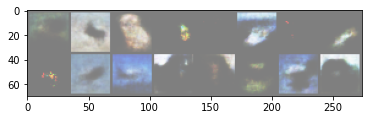

Training Mode...
[25,    50] train loss: 0.164
[25,   100] train loss: 0.173
[25,   150] train loss: 0.171
[25,   200] train loss: 0.171
[25,   250] train loss: 0.162
[25,   300] train loss: 0.167
Validation Mode...
[25, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


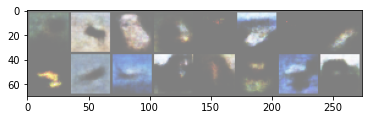

Training Mode...
[26,    50] train loss: 0.172
[26,   100] train loss: 0.159
[26,   150] train loss: 0.165
[26,   200] train loss: 0.173
[26,   250] train loss: 0.167
[26,   300] train loss: 0.170
Validation Mode...
[26, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


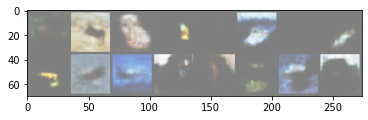

Training Mode...
[27,    50] train loss: 0.171
[27,   100] train loss: 0.165
[27,   150] train loss: 0.168
[27,   200] train loss: 0.169
[27,   250] train loss: 0.164
[27,   300] train loss: 0.171
Validation Mode...
[27, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


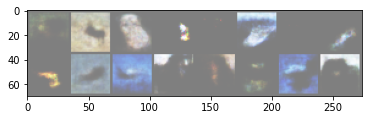

Training Mode...
[28,    50] train loss: 0.168
[28,   100] train loss: 0.167
[28,   150] train loss: 0.163
[28,   200] train loss: 0.171
[28,   250] train loss: 0.167
[28,   300] train loss: 0.169
Validation Mode...
[28, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


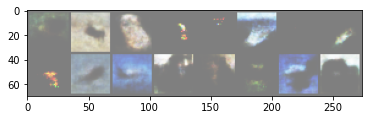

Training Mode...
[29,    50] train loss: 0.172
[29,   100] train loss: 0.166
[29,   150] train loss: 0.161
[29,   200] train loss: 0.166
[29,   250] train loss: 0.169
[29,   300] train loss: 0.162
Validation Mode...
[29, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


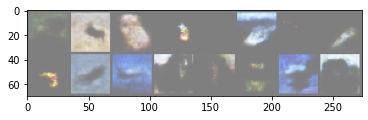

Training Mode...
[30,    50] train loss: 0.160
[30,   100] train loss: 0.167
[30,   150] train loss: 0.165
[30,   200] train loss: 0.162
[30,   250] train loss: 0.168
[30,   300] train loss: 0.172
Validation Mode...
[30, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


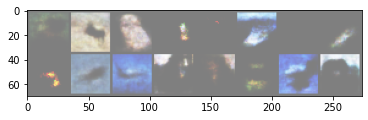

Training Mode...
[31,    50] train loss: 0.166
[31,   100] train loss: 0.169
[31,   150] train loss: 0.163
[31,   200] train loss: 0.167
[31,   250] train loss: 0.161
[31,   300] train loss: 0.167
Validation Mode...
[31, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


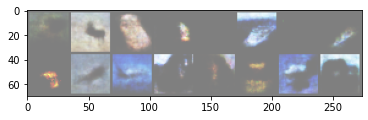

Training Mode...
[32,    50] train loss: 0.163
[32,   100] train loss: 0.164
[32,   150] train loss: 0.162
[32,   200] train loss: 0.165
[32,   250] train loss: 0.170
[32,   300] train loss: 0.170
Validation Mode...
[32, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


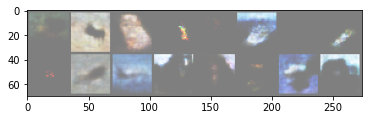

Training Mode...
[33,    50] train loss: 0.164
[33,   100] train loss: 0.170
[33,   150] train loss: 0.165
[33,   200] train loss: 0.160
[33,   250] train loss: 0.165
[33,   300] train loss: 0.163
Validation Mode...
[33, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


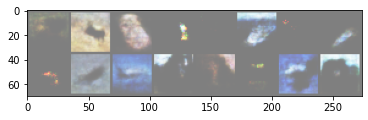

Training Mode...
[34,    50] train loss: 0.169
[34,   100] train loss: 0.161
[34,   150] train loss: 0.166
[34,   200] train loss: 0.163
[34,   250] train loss: 0.166
[34,   300] train loss: 0.159
Validation Mode...
[34, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


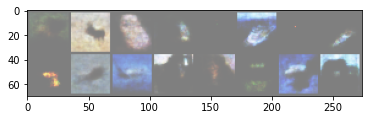

Training Mode...
[35,    50] train loss: 0.163
[35,   100] train loss: 0.162
[35,   150] train loss: 0.161
[35,   200] train loss: 0.161
[35,   250] train loss: 0.166
[35,   300] train loss: 0.164
Validation Mode...
[35, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


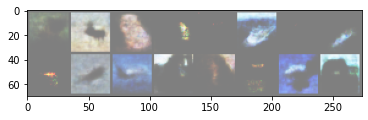

Training Mode...
[36,    50] train loss: 0.159
[36,   100] train loss: 0.159
[36,   150] train loss: 0.164
[36,   200] train loss: 0.167
[36,   250] train loss: 0.168
[36,   300] train loss: 0.162
Validation Mode...
[36, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


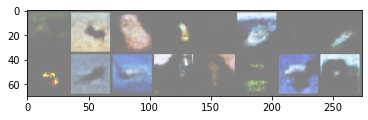

Training Mode...
[37,    50] train loss: 0.163
[37,   100] train loss: 0.166
[37,   150] train loss: 0.165
[37,   200] train loss: 0.160
[37,   250] train loss: 0.156
[37,   300] train loss: 0.162
Validation Mode...
[37, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


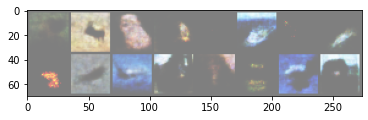

Training Mode...
[38,    50] train loss: 0.163
[38,   100] train loss: 0.162
[38,   150] train loss: 0.158
[38,   200] train loss: 0.162
[38,   250] train loss: 0.166
[38,   300] train loss: 0.161
Validation Mode...
[38, _] validation loss: 0.179
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


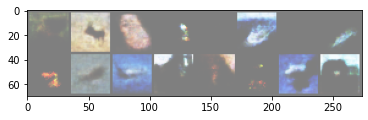

Training Mode...
[39,    50] train loss: 0.160
[39,   100] train loss: 0.161
[39,   150] train loss: 0.160
[39,   200] train loss: 0.162
[39,   250] train loss: 0.161
[39,   300] train loss: 0.161
Validation Mode...
[39, _] validation loss: 0.187
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


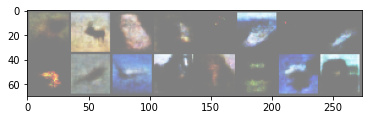

Training Mode...
[40,    50] train loss: 0.155
[40,   100] train loss: 0.161
[40,   150] train loss: 0.161
[40,   200] train loss: 0.161
[40,   250] train loss: 0.165
[40,   300] train loss: 0.163
Validation Mode...
[40, _] validation loss: 0.179
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


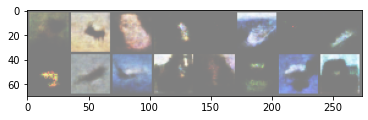

Training Mode...
[41,    50] train loss: 0.155
[41,   100] train loss: 0.160
[41,   150] train loss: 0.164
[41,   200] train loss: 0.162
[41,   250] train loss: 0.158
[41,   300] train loss: 0.165
Validation Mode...
[41, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


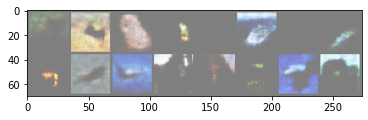

Training Mode...
[42,    50] train loss: 0.164
[42,   100] train loss: 0.159
[42,   150] train loss: 0.158
[42,   200] train loss: 0.163
[42,   250] train loss: 0.161
[42,   300] train loss: 0.160
Validation Mode...
[42, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


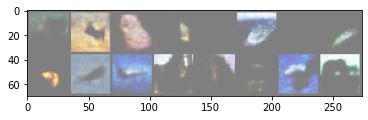

Training Mode...
[43,    50] train loss: 0.159
[43,   100] train loss: 0.160
[43,   150] train loss: 0.162
[43,   200] train loss: 0.159
[43,   250] train loss: 0.156
[43,   300] train loss: 0.163
Validation Mode...
[43, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


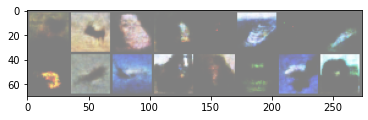

Training Mode...
[44,    50] train loss: 0.159
[44,   100] train loss: 0.164
[44,   150] train loss: 0.165
[44,   200] train loss: 0.156
[44,   250] train loss: 0.157
[44,   300] train loss: 0.162
Validation Mode...
[44, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


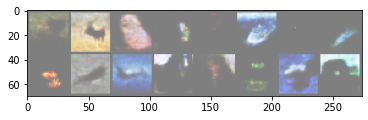

Training Mode...
[45,    50] train loss: 0.165
[45,   100] train loss: 0.160
[45,   150] train loss: 0.163
[45,   200] train loss: 0.154
[45,   250] train loss: 0.155
[45,   300] train loss: 0.160
Validation Mode...
[45, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


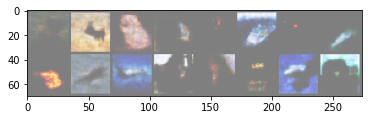

Training Mode...
[46,    50] train loss: 0.156
[46,   100] train loss: 0.154
[46,   150] train loss: 0.157
[46,   200] train loss: 0.163
[46,   250] train loss: 0.164
[46,   300] train loss: 0.162
Validation Mode...
[46, _] validation loss: 0.179
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


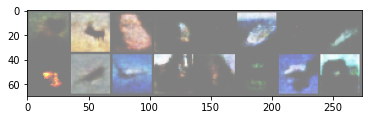

Training Mode...
[47,    50] train loss: 0.162
[47,   100] train loss: 0.158
[47,   150] train loss: 0.158
[47,   200] train loss: 0.165
[47,   250] train loss: 0.156
[47,   300] train loss: 0.160
Validation Mode...
[47, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


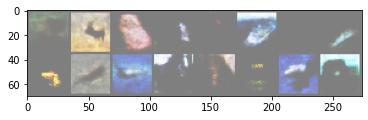

Training Mode...
[48,    50] train loss: 0.156
[48,   100] train loss: 0.159
[48,   150] train loss: 0.163
[48,   200] train loss: 0.157
[48,   250] train loss: 0.163
[48,   300] train loss: 0.157
Validation Mode...
[48, _] validation loss: 0.186
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


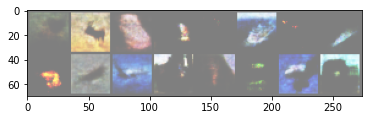

Training Mode...
[49,    50] train loss: 0.159
[49,   100] train loss: 0.163
[49,   150] train loss: 0.158
[49,   200] train loss: 0.161
[49,   250] train loss: 0.156
[49,   300] train loss: 0.158
Validation Mode...
[49, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


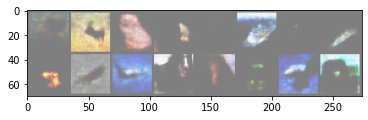

Training Mode...
[50,    50] train loss: 0.152
[50,   100] train loss: 0.161
[50,   150] train loss: 0.160
[50,   200] train loss: 0.159
[50,   250] train loss: 0.158
[50,   300] train loss: 0.156
Validation Mode...
[50, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


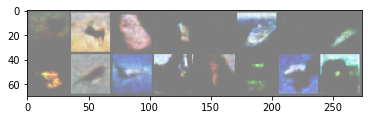

Training Mode...
[51,    50] train loss: 0.162
[51,   100] train loss: 0.157
[51,   150] train loss: 0.159
[51,   200] train loss: 0.154
[51,   250] train loss: 0.165
[51,   300] train loss: 0.159
Validation Mode...
[51, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


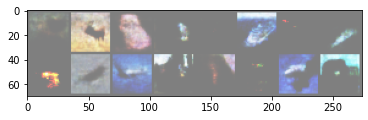

Training Mode...
[52,    50] train loss: 0.156
[52,   100] train loss: 0.161
[52,   150] train loss: 0.166
[52,   200] train loss: 0.151
[52,   250] train loss: 0.155
[52,   300] train loss: 0.159
Validation Mode...
[52, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


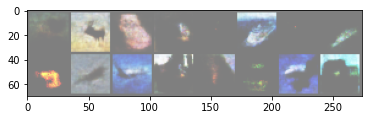

Training Mode...
[53,    50] train loss: 0.156
[53,   100] train loss: 0.154
[53,   150] train loss: 0.155
[53,   200] train loss: 0.160
[53,   250] train loss: 0.159
[53,   300] train loss: 0.161
Validation Mode...
[53, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


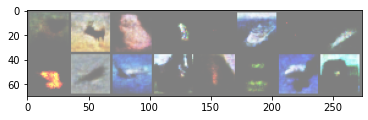

Training Mode...
[54,    50] train loss: 0.151
[54,   100] train loss: 0.162
[54,   150] train loss: 0.159
[54,   200] train loss: 0.158
[54,   250] train loss: 0.156
[54,   300] train loss: 0.156
Validation Mode...
[54, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


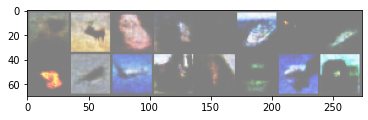

Training Mode...
[55,    50] train loss: 0.159
[55,   100] train loss: 0.157
[55,   150] train loss: 0.154
[55,   200] train loss: 0.156
[55,   250] train loss: 0.157
[55,   300] train loss: 0.160
Validation Mode...
[55, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


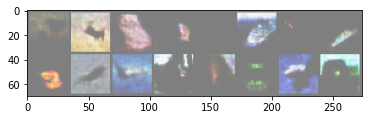

Training Mode...
[56,    50] train loss: 0.162
[56,   100] train loss: 0.155
[56,   150] train loss: 0.158
[56,   200] train loss: 0.145
[56,   250] train loss: 0.160
[56,   300] train loss: 0.160
Validation Mode...
[56, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


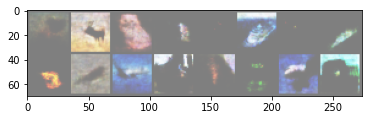

Training Mode...
[57,    50] train loss: 0.156
[57,   100] train loss: 0.145
[57,   150] train loss: 0.160
[57,   200] train loss: 0.163
[57,   250] train loss: 0.159
[57,   300] train loss: 0.154
Validation Mode...
[57, _] validation loss: 0.179
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


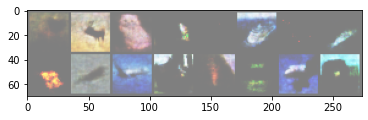

Training Mode...
[58,    50] train loss: 0.159
[58,   100] train loss: 0.155
[58,   150] train loss: 0.158
[58,   200] train loss: 0.151
[58,   250] train loss: 0.159
[58,   300] train loss: 0.157
Validation Mode...
[58, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


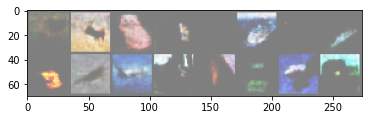

Training Mode...
[59,    50] train loss: 0.159
[59,   100] train loss: 0.157
[59,   150] train loss: 0.156
[59,   200] train loss: 0.157
[59,   250] train loss: 0.154
[59,   300] train loss: 0.157
Validation Mode...
[59, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


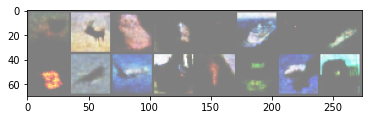

Training Mode...
[60,    50] train loss: 0.155
[60,   100] train loss: 0.159
[60,   150] train loss: 0.156
[60,   200] train loss: 0.158
[60,   250] train loss: 0.156
[60,   300] train loss: 0.153
Validation Mode...
[60, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


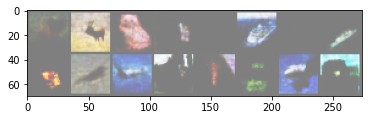

Training Mode...
[61,    50] train loss: 0.153
[61,   100] train loss: 0.158
[61,   150] train loss: 0.157
[61,   200] train loss: 0.153
[61,   250] train loss: 0.160
[61,   300] train loss: 0.153
Validation Mode...
[61, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


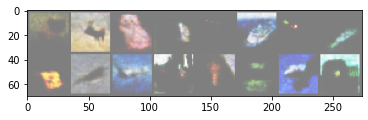

Training Mode...
[62,    50] train loss: 0.159
[62,   100] train loss: 0.151
[62,   150] train loss: 0.154
[62,   200] train loss: 0.155
[62,   250] train loss: 0.158
[62,   300] train loss: 0.155
Validation Mode...
[62, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


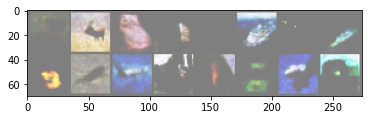

Training Mode...
[63,    50] train loss: 0.153
[63,   100] train loss: 0.157
[63,   150] train loss: 0.157
[63,   200] train loss: 0.157
[63,   250] train loss: 0.152
[63,   300] train loss: 0.156
Validation Mode...
[63, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


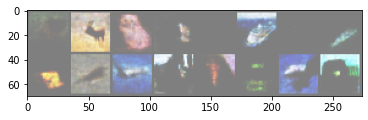

Training Mode...
[64,    50] train loss: 0.159
[64,   100] train loss: 0.152
[64,   150] train loss: 0.162
[64,   200] train loss: 0.157
[64,   250] train loss: 0.152
[64,   300] train loss: 0.150
Validation Mode...
[64, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


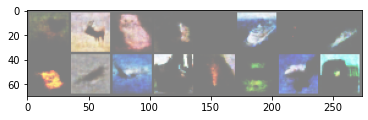

Training Mode...
[65,    50] train loss: 0.157
[65,   100] train loss: 0.152
[65,   150] train loss: 0.155
[65,   200] train loss: 0.158
[65,   250] train loss: 0.156
[65,   300] train loss: 0.152
Validation Mode...
[65, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


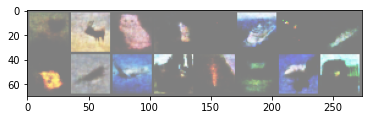

Training Mode...
[66,    50] train loss: 0.151
[66,   100] train loss: 0.150
[66,   150] train loss: 0.156
[66,   200] train loss: 0.163
[66,   250] train loss: 0.156
[66,   300] train loss: 0.153
Validation Mode...
[66, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


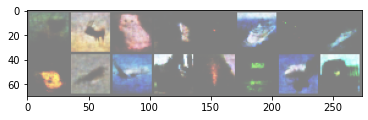

Training Mode...
[67,    50] train loss: 0.153
[67,   100] train loss: 0.156
[67,   150] train loss: 0.160
[67,   200] train loss: 0.151
[67,   250] train loss: 0.155
[67,   300] train loss: 0.153
Validation Mode...
[67, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


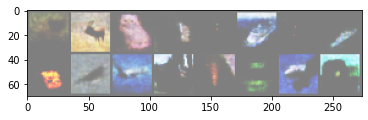

Training Mode...
[68,    50] train loss: 0.155
[68,   100] train loss: 0.153
[68,   150] train loss: 0.156
[68,   200] train loss: 0.157
[68,   250] train loss: 0.155
[68,   300] train loss: 0.150
Validation Mode...
[68, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


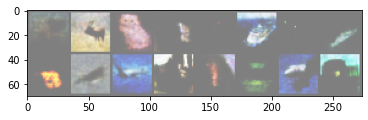

Training Mode...
[69,    50] train loss: 0.151
[69,   100] train loss: 0.157
[69,   150] train loss: 0.155
[69,   200] train loss: 0.158
[69,   250] train loss: 0.153
[69,   300] train loss: 0.154
Validation Mode...
[69, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


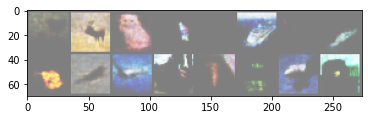

Training Mode...
[70,    50] train loss: 0.153
[70,   100] train loss: 0.157
[70,   150] train loss: 0.155
[70,   200] train loss: 0.152
[70,   250] train loss: 0.146
[70,   300] train loss: 0.164
Validation Mode...
[70, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


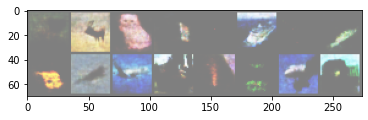

Training Mode...
[71,    50] train loss: 0.154
[71,   100] train loss: 0.151
[71,   150] train loss: 0.154
[71,   200] train loss: 0.158
[71,   250] train loss: 0.157
[71,   300] train loss: 0.151
Validation Mode...
[71, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


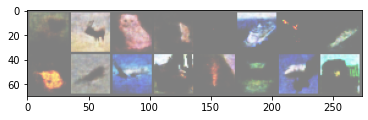

Training Mode...
[72,    50] train loss: 0.155
[72,   100] train loss: 0.153
[72,   150] train loss: 0.154
[72,   200] train loss: 0.153
[72,   250] train loss: 0.158
[72,   300] train loss: 0.151
Validation Mode...
[72, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


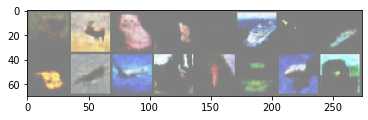

Training Mode...
[73,    50] train loss: 0.153
[73,   100] train loss: 0.155
[73,   150] train loss: 0.156
[73,   200] train loss: 0.153
[73,   250] train loss: 0.155
[73,   300] train loss: 0.152
Validation Mode...
[73, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


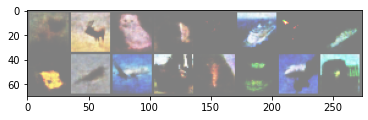

Training Mode...
[74,    50] train loss: 0.155
[74,   100] train loss: 0.157
[74,   150] train loss: 0.148
[74,   200] train loss: 0.150
[74,   250] train loss: 0.152
[74,   300] train loss: 0.160
Validation Mode...
[74, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


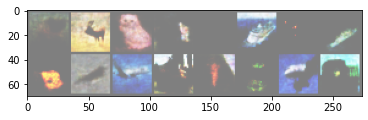

Training Mode...
[75,    50] train loss: 0.159
[75,   100] train loss: 0.152
[75,   150] train loss: 0.153
[75,   200] train loss: 0.153
[75,   250] train loss: 0.154
[75,   300] train loss: 0.152
Validation Mode...
[75, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


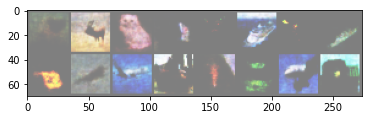

Training Mode...
[76,    50] train loss: 0.151
[76,   100] train loss: 0.152
[76,   150] train loss: 0.158
[76,   200] train loss: 0.154
[76,   250] train loss: 0.152
[76,   300] train loss: 0.152
Validation Mode...
[76, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


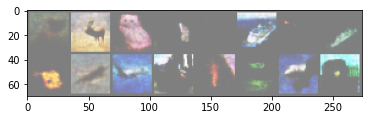

Training Mode...
[77,    50] train loss: 0.154
[77,   100] train loss: 0.159
[77,   150] train loss: 0.155
[77,   200] train loss: 0.153
[77,   250] train loss: 0.148
[77,   300] train loss: 0.150
Validation Mode...
[77, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


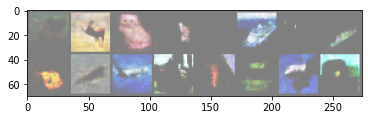

Training Mode...
[78,    50] train loss: 0.150
[78,   100] train loss: 0.149
[78,   150] train loss: 0.156
[78,   200] train loss: 0.154
[78,   250] train loss: 0.157
[78,   300] train loss: 0.156
Validation Mode...
[78, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


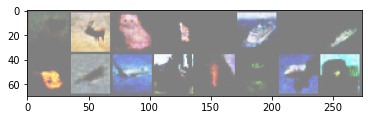

Training Mode...
[79,    50] train loss: 0.157
[79,   100] train loss: 0.153
[79,   150] train loss: 0.153
[79,   200] train loss: 0.155
[79,   250] train loss: 0.147
[79,   300] train loss: 0.152
Validation Mode...
[79, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


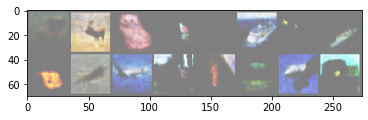

Training Mode...
[80,    50] train loss: 0.152
[80,   100] train loss: 0.152
[80,   150] train loss: 0.157
[80,   200] train loss: 0.150
[80,   250] train loss: 0.154
[80,   300] train loss: 0.156
Validation Mode...
[80, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


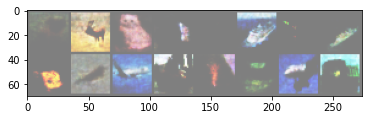

Training Mode...
[81,    50] train loss: 0.147
[81,   100] train loss: 0.157
[81,   150] train loss: 0.152
[81,   200] train loss: 0.154
[81,   250] train loss: 0.146
[81,   300] train loss: 0.161
Validation Mode...
[81, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


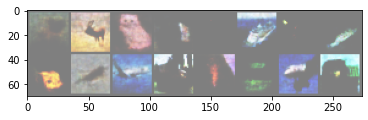

Training Mode...
[82,    50] train loss: 0.154
[82,   100] train loss: 0.149
[82,   150] train loss: 0.157
[82,   200] train loss: 0.155
[82,   250] train loss: 0.153
[82,   300] train loss: 0.152
Validation Mode...
[82, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


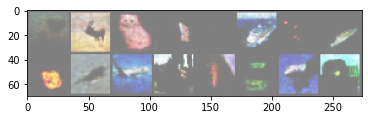

Training Mode...
[83,    50] train loss: 0.152
[83,   100] train loss: 0.150
[83,   150] train loss: 0.148
[83,   200] train loss: 0.156
[83,   250] train loss: 0.157
[83,   300] train loss: 0.154
Validation Mode...
[83, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


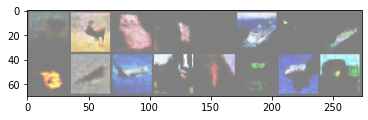

Training Mode...
[84,    50] train loss: 0.151
[84,   100] train loss: 0.153
[84,   150] train loss: 0.147
[84,   200] train loss: 0.156
[84,   250] train loss: 0.158
[84,   300] train loss: 0.152
Validation Mode...
[84, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


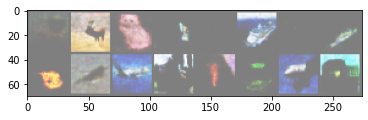

Training Mode...
[85,    50] train loss: 0.152
[85,   100] train loss: 0.148
[85,   150] train loss: 0.151
[85,   200] train loss: 0.158
[85,   250] train loss: 0.157
[85,   300] train loss: 0.153
Validation Mode...
[85, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


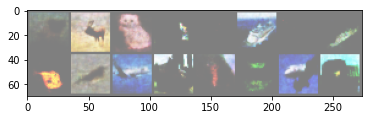

Training Mode...
[86,    50] train loss: 0.152
[86,   100] train loss: 0.150
[86,   150] train loss: 0.157
[86,   200] train loss: 0.154
[86,   250] train loss: 0.152
[86,   300] train loss: 0.152
Validation Mode...
[86, _] validation loss: 0.180
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


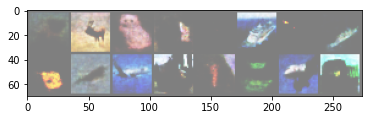

Training Mode...
[87,    50] train loss: 0.152
[87,   100] train loss: 0.151
[87,   150] train loss: 0.154
[87,   200] train loss: 0.149
[87,   250] train loss: 0.156
[87,   300] train loss: 0.153
Validation Mode...
[87, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


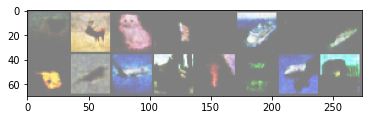

Training Mode...
[88,    50] train loss: 0.151
[88,   100] train loss: 0.152
[88,   150] train loss: 0.150
[88,   200] train loss: 0.152
[88,   250] train loss: 0.155
[88,   300] train loss: 0.154
Validation Mode...
[88, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


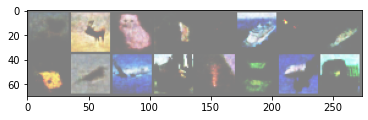

Training Mode...
[89,    50] train loss: 0.149
[89,   100] train loss: 0.146
[89,   150] train loss: 0.156
[89,   200] train loss: 0.154
[89,   250] train loss: 0.156
[89,   300] train loss: 0.153
Validation Mode...
[89, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


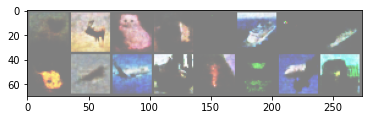

Training Mode...
[90,    50] train loss: 0.154
[90,   100] train loss: 0.142
[90,   150] train loss: 0.153
[90,   200] train loss: 0.149
[90,   250] train loss: 0.157
[90,   300] train loss: 0.159
Validation Mode...
[90, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


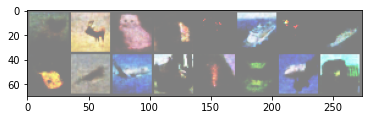

Training Mode...
[91,    50] train loss: 0.150
[91,   100] train loss: 0.151
[91,   150] train loss: 0.151
[91,   200] train loss: 0.152
[91,   250] train loss: 0.154
[91,   300] train loss: 0.153
Validation Mode...
[91, _] validation loss: 0.187
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


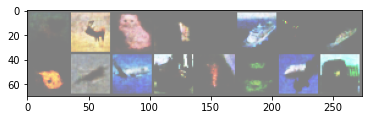

Training Mode...
[92,    50] train loss: 0.149
[92,   100] train loss: 0.153
[92,   150] train loss: 0.153
[92,   200] train loss: 0.151
[92,   250] train loss: 0.151
[92,   300] train loss: 0.153
Validation Mode...
[92, _] validation loss: 0.185
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


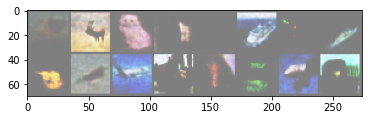

Training Mode...
[93,    50] train loss: 0.153
[93,   100] train loss: 0.151
[93,   150] train loss: 0.155
[93,   200] train loss: 0.148
[93,   250] train loss: 0.152
[93,   300] train loss: 0.152
Validation Mode...
[93, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


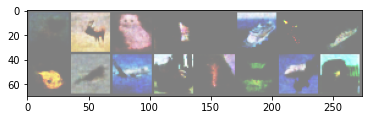

Training Mode...
[94,    50] train loss: 0.150
[94,   100] train loss: 0.157
[94,   150] train loss: 0.147
[94,   200] train loss: 0.147
[94,   250] train loss: 0.154
[94,   300] train loss: 0.152
Validation Mode...
[94, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


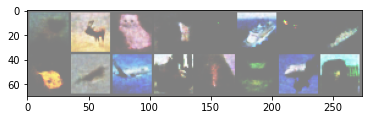

Training Mode...
[95,    50] train loss: 0.151
[95,   100] train loss: 0.151
[95,   150] train loss: 0.157
[95,   200] train loss: 0.147
[95,   250] train loss: 0.153
[95,   300] train loss: 0.149
Validation Mode...
[95, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


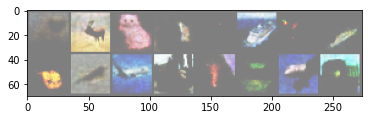

Training Mode...
[96,    50] train loss: 0.152
[96,   100] train loss: 0.150
[96,   150] train loss: 0.153
[96,   200] train loss: 0.157
[96,   250] train loss: 0.145
[96,   300] train loss: 0.151
Validation Mode...
[96, _] validation loss: 0.182
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


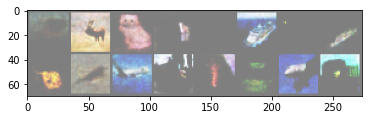

Training Mode...
[97,    50] train loss: 0.149
[97,   100] train loss: 0.154
[97,   150] train loss: 0.148
[97,   200] train loss: 0.159
[97,   250] train loss: 0.154
[97,   300] train loss: 0.150
Validation Mode...
[97, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


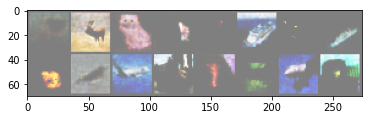

Training Mode...
[98,    50] train loss: 0.146
[98,   100] train loss: 0.156
[98,   150] train loss: 0.155
[98,   200] train loss: 0.154
[98,   250] train loss: 0.155
[98,   300] train loss: 0.144
Validation Mode...
[98, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


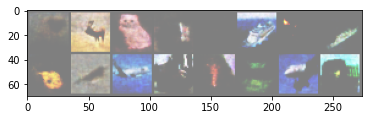

Training Mode...
[99,    50] train loss: 0.152
[99,   100] train loss: 0.151
[99,   150] train loss: 0.147
[99,   200] train loss: 0.153
[99,   250] train loss: 0.151
[99,   300] train loss: 0.155
Validation Mode...
[99, _] validation loss: 0.184
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


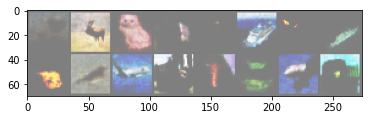

Training Mode...
[100,    50] train loss: 0.148
[100,   100] train loss: 0.155
[100,   150] train loss: 0.151
[100,   200] train loss: 0.151
[100,   250] train loss: 0.148
[100,   300] train loss: 0.152
Validation Mode...
[100, _] validation loss: 0.181
images_color:  torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])


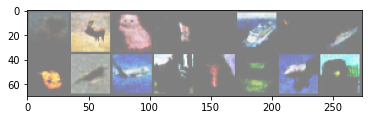

Finished Training


In [6]:
for epoch in range(100):  # loop over the dataset multiple times
    train_running_loss = 0.0
    valid_running_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    print("Training Mode...")
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)
        
        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)
    
        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        train_loss = criterion(outputs, images_color_flat)
        train_loss.backward()
        optimizer.step()

        # print output statistics
        train_running_loss += train_loss.item()
        
        j = 50              # print every j mini-batches
        if i % j == (j-1):     # print every j mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / j))
            
            writer.add_scalar('Loss/train', train_running_loss/j, len(trainloader)*epoch + i)
            train_running_loss = 0.0
        
    ###################
    # validate the model #
    ###################
    model.eval()
    print("Validation Mode...")
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images_color, _ = data
            images_gray = rgb2gray_batch(images_color)

            # flatten and put data into gpu/cpu
            images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
            images_color_flat = images_color.reshape(images_color.shape[0], -1)
            images_gray_flat = images_gray_flat.to(device)
            images_color_flat = images_color_flat.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Size - images_gray: [batchSize, 1024]
            outputs = model(images_gray_flat)

            # Backward
            # Size - images_color_flat: [batchSize,3072]
            # Size - outputs: [batchSize,3072]
            valid_loss = criterion(outputs, images_color_flat)

            # print output statistics
            valid_running_loss += valid_loss.item()
    
        print('[%d, _] validation loss: %.3f' %
              (epoch + 1, valid_running_loss/(i+1)))

        writer.add_scalar('Loss/valid', valid_running_loss/(i+1), len(trainloader)*(epoch+1))
        valid_running_loss = 0.0
        
    # Save the summary of output image, after each epoch
    make_grid(fixed_trainloader, epoch)

writer.flush()
writer.close()
plot_writer.flush()
plot_writer.close()
print('Finished Training')

### Inference

In [7]:
def inference(loaderName, prefix):
    
    images_color, _ = next(iter(loaderName))
    print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
    imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference/"+prefix+"color")

    images_gray = rgb2gray_batch(images_color)
    print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
    imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference/"+ prefix+"gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    imshow(torchvision.utils.make_grid(outputs.detach()), name="inference/"+prefix+"output")

images_color:  torch.Size([16, 3, 32, 32])


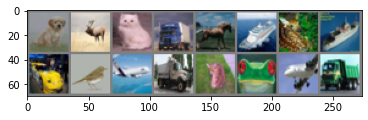

images_gray:  torch.Size([16, 32, 32])


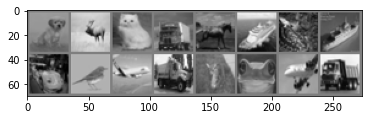

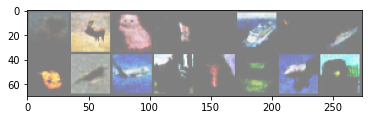

images_color:  torch.Size([16, 3, 32, 32])


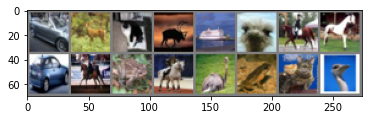

images_gray:  torch.Size([16, 32, 32])


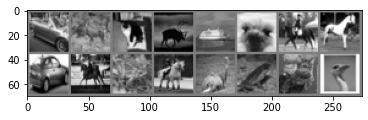

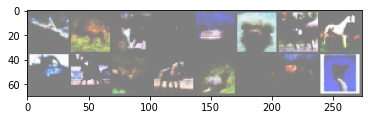

images_color:  torch.Size([16, 3, 32, 32])


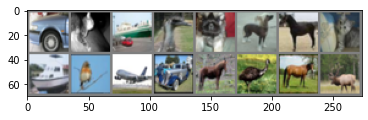

images_gray:  torch.Size([16, 32, 32])


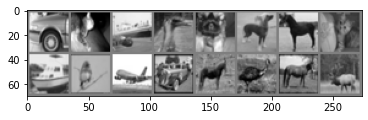

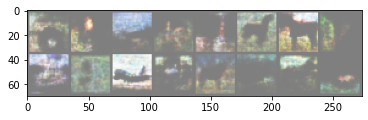

images_color:  torch.Size([16, 3, 32, 32])


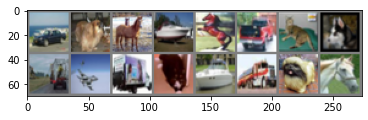

images_gray:  torch.Size([16, 32, 32])


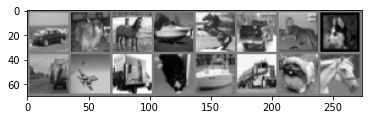

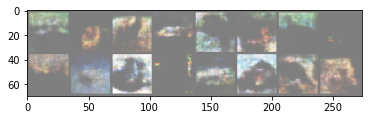

In [11]:
inference(fixed_trainloader, "train")
inference(trainloader, "train")
inference(validloader, "valid")
inference(testloader, "test")

### Test the model

In [9]:
###################
# test the model #
###################
model.eval()
test_running_loss = 0.0
print("Test Mode...")
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)

        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)

        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        test_loss = criterion(outputs, images_color_flat)

        # print output statistics
        test_running_loss += test_loss.item()

    print('test loss: %.5f' %
          (test_running_loss/(i+1)))

Test Mode...
test loss: 0.17242


### Save the model

In [10]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
torch.save(model.state_dict(), model_path)